In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import networkx as nx

In [2]:
import sys
sys.path.append('../../code')

import min_vertex_k_cut

In [3]:
drd2_hi = pd.read_csv('../../data/raw/drd2_hi.csv', index_col=0)
drd2_hi

,smiles,value
0,Brc1ccc(-[n+]2cc[n+](Cc3ccccc3)cc2)c2cc[nH]c12,True
1,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,False
2,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,True
3,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,True
4,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,True
...,...,...
6262,c1cnc(N2CCN(CCCOc3ccc(-c4nc5ccccc5o4)cc3)CC2)nc1,True
6263,c1cnc(N2CCN(CCCSc3nc4ccccc4s3)CC2)nc1,True
6264,c1cnc(N2CCN(Cc3c[nH]c4ncccc34)CC2)nc1,False
6265,c1cncc(CN[C@H]2C3C4CC5C6C4CC3C6C52)c1,False


In [4]:
smiles = drd2_hi['smiles'].to_list()
threshold = 0.4

neighborhood_graph = min_vertex_k_cut.get_neighborhood_graph(smiles, threshold)
main_component, small_components = min_vertex_k_cut.get_main_component(neighborhood_graph)

old_nodes_to_new = dict(zip(main_component.nodes(), range(main_component.number_of_nodes())))
new_nodes_to_old = {v: k for k, v in old_nodes_to_new.items()}
main_component = nx.relabel_nodes(main_component, old_nodes_to_new)

In [5]:
for coarse_threhold in [0.90, 0.80, 0.70, 0.60, 0.50, 0.40]:
    coarsed_main_component, _ = min_vertex_k_cut.coarse_graph(main_component, coarse_threhold)
    node_degrees = list(dict(coarsed_main_component.degree()).values())
    print(coarse_threhold, len(coarsed_main_component), np.mean(node_degrees))

0.9 5160 86.87093023255814
0.8 3696 56.81547619047619
0.7 1963 34.751910341314314
0.6 1128 24.48049645390071
0.5 648 17.126543209876544
0.4 387 11.534883720930232


In [6]:
coarsed_main_component, node_to_cluster = min_vertex_k_cut.coarse_graph(main_component, 0.4)

In [7]:
model = min_vertex_k_cut.trisect_connected_graph(coarsed_main_component, part_min_frac=0.18, emphasis=1, max_mip_gap=0.5)

Total molecules: 6082
Min size of a partition: 1094
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 12621 (-1161) rows, 1161 (0) columns and 26784 (-2322) elements
Clp1000I sum of infeasibilities 7.43375e-07 - average 5.88998e-11, 0 fixed columns
Coin0506I Presolve 12621 (0) rows, 1161 (0) columns and 26784 (0) elements
Clp0029I End of values pass after 1161 iterations
Clp0000I Optimal - objective value 6082
Clp0000I Optimal - objective value 6082
Clp0000I Optimal - objective value 6082
Coin0511I After Postsolve, objective 6082, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 6082 - 0 iterations time 0.642, Presolve 0.01, Idiot 0.63

Starting MIP optimization
Cgl0003I 0 fixed, 0 tightened bounds, 10464 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1714 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tigh

In [8]:
model.status

<OptimizationStatus.OPTIMAL: 0>

In [9]:
split = min_vertex_k_cut.process_trisect_results(model, coarsed_main_component, main_component, node_to_cluster)

[2692 1098 1194 1098]


In [10]:
first_idx = []
second_idx = []
third_idx = []

for S_idx, partition in enumerate(split):
    G_idx = new_nodes_to_old[S_idx]
    if partition == 0:
        first_idx.append(G_idx)
    if partition == 1:
        second_idx.append(G_idx)
    if partition == 2:
        third_idx.append(G_idx)

In [16]:
for component in small_components:
    i = np.argmin([len(first_idx), len(second_idx), len(third_idx)])
    if i == 0:
        first_idx.extend(component)
    if i == 1:
        second_idx.extend(component)
    if i == 2:
        third_idx.extend(component)

In [17]:
[len(first_idx), len(second_idx), len(third_idx)]

[1191, 1194, 1190]

In [19]:
part_first = drd2_hi.iloc[first_idx]
part_second = drd2_hi.iloc[second_idx]
part_third = drd2_hi.iloc[third_idx]


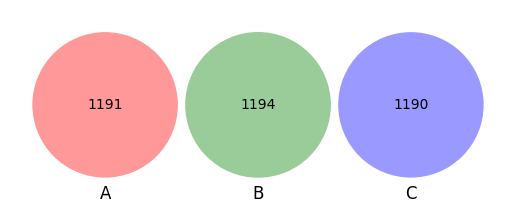

In [21]:
venn3([
    set(part_first['smiles'].tolist()),
    set(part_second['smiles'].tolist()),
    set(part_third['smiles'].tolist()),
])

In [23]:
train_1 = pd.concat([part_first, part_second])
test_1 = part_third.copy()

train_2 = pd.concat([part_first, part_third])
test_2 = part_second.copy()

train_3 = pd.concat([part_second, part_third])
test_3 = part_first.copy()

In [24]:
min_vertex_k_cut.test_split(train_1['smiles'], test_1['smiles'], threshold=0.4)

In [25]:
min_vertex_k_cut.test_split(train_2['smiles'], test_2['smiles'], threshold=0.4)

In [26]:
min_vertex_k_cut.test_split(train_3['smiles'], test_3['smiles'], threshold=0.4)

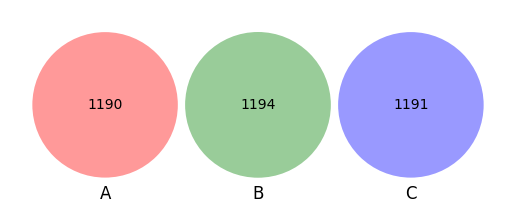

In [27]:
venn3([
    set(test_1['smiles'].tolist()),
    set(test_2['smiles'].tolist()),
    set(test_3['smiles'].tolist()),
])

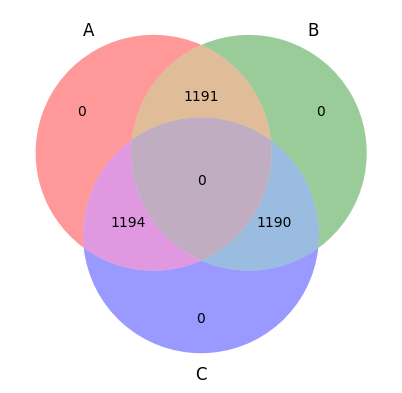

In [28]:
venn3([
    set(train_1['smiles'].tolist()),
    set(train_2['smiles'].tolist()),
    set(train_3['smiles'].tolist()),
])

In [29]:
train_1.to_csv('../../data/hi/drd2/train_1.csv')
train_2.to_csv('../../data/hi/drd2/train_2.csv')
train_3.to_csv('../../data/hi/drd2/train_3.csv')

In [30]:
test_1.to_csv('../../data/hi/drd2/test_1.csv')
test_2.to_csv('../../data/hi/drd2/test_2.csv')
test_3.to_csv('../../data/hi/drd2/test_3.csv')